In [24]:
# all useful imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
from wordcloud import WordCloud, STOPWORDS # this module is for making wordcloud in python
import re # regular expression
import string # for finding punctuation in text
import nltk # preprocessing text
from collections import Counter 
from textblob import TextBlob
from matplotlib.pyplot import text
#import tweepy as tw
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
import re
import networkx as nx
import warnings
warnings.filterwarnings("ignore")
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
from pandas.core.common import flatten
from plotly.offline import plot
import plotly.graph_objs as go
import plotly.express as px

## Food poisoning restaurants

For the sake of our study, we focus our analysis on restaurants that have failed inspections. The goal is to inspect ratings and reviews related to these restaurants to see if they are negative. Also, a step of the work is to cross them with the food inspection data-set to make analysis of reviews and ratings around inspection dates

### Load Data

In [2]:
shaws = pd.read_csv('data/shaws.csv').drop(columns=['Unnamed: 0'])
giordanos = pd.read_csv('data/Giordanos.csv').drop(columns=['Unnamed: 0'])
ghareeb = pd.read_csv('data/ghareeb.csv').drop(columns=['Unnamed: 0'])
ginos = pd.read_csv('data/ginos.csv').drop(columns=['Unnamed: 0'])
iyanze = pd.read_csv('data/iyanze.csv').drop(columns=['Unnamed: 0'])
chilis = pd.read_csv('data/chilis.csv').drop(columns=['Unnamed: 0'])
dominos = pd.read_csv('data/dominos-pizza-chicago-22.csv').drop(columns=['Unnamed: 0'])
mcdo70 = pd.read_csv('data/mcdonalds-chicago-70.csv').drop(columns=['Unnamed: 0'])
mcdo95 = pd.read_csv('data/mcdonalds-chicago-95.csv').drop(columns=['Unnamed: 0'])
mcdo19 = pd.read_csv('data/mcdonalds-chicago-19.csv').drop(columns=['Unnamed: 0'])
chipotle = pd.read_csv('data/chipotle-mexican-grill-chicago-29.csv').drop(columns=['Unnamed: 0'])
giordanos19 = pd.read_csv('data/giordanos-chicago-19.csv').drop(columns=['Unnamed: 0'])
reviews = pd.concat([shaws, giordanos, ghareeb, ginos, iyanze, chilis, dominos, mcdo70, mcdo95, mcdo19, chipotle,giordanos19])
reviews = reviews.reset_index(drop= True)

#Extract rating from reviewRating
reviews["rating"]=reviews["reviewRating"].str.extract('(\d+)')
reviews = reviews.astype({'rating': 'int32'}).drop(columns=['reviewRating'])
reviews.head()

datePublished                                        description  \
0    2019-12-11  Not only did we have brunch on Sunday, Decembe...   
1    2019-12-07  Shaw's has been around  for quite some time in...   
2    2019-12-05  What a disappointing experience at what used t...   
3    2019-11-22  10,10,10,10,10\nthis is exactly how I feel abo...   
4    2019-10-23  Weekend brunch ... King Crab Legs ... All-You-...   

        author                     alias  rating  
0  Carol A. R.  shaws-crab-house-chicago       5  
1   Richard S.  shaws-crab-house-chicago       4  
2     Emily I.  shaws-crab-house-chicago       1  
3    Ronald S.  shaws-crab-house-chicago       5  
4   Michael S.  shaws-crab-house-chicago       4

In [3]:
# Introduce a preprocessing function to get rid of stopwords in the description of reviews
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())                  # get rid of noise
    x = [w for w in x.split() if w not in set(stopwords)]  # remove stopwords
    return ' '.join(x) # then join the text again

In [4]:
# Constructing a list of stopwords

# download all stopwords from the nltk library
nltk.download('stopwords')

# get a list of all english stopwords
i = nltk.corpus.stopwords.words('english')

# get a list of all punctuations
j = list(string.punctuation)

stopwords = set(i).union(j)

# Introduce a preprocessing function to get rid of stopwords in the description of reviews
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())                  # get rid of noise
    x = [w for w in x.split() if w not in set(stopwords)]  # remove stopwords
    return ' '.join(x) # then join the text again

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aymenayadi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# filter the column description according to the stopwords 
reviews["description_filtered"]= reviews.apply(lambda row : preprocess(row['description']) , axis = 1)
reviews

datePublished                                        description  \
0       2019-12-11  Not only did we have brunch on Sunday, Decembe...   
1       2019-12-07  Shaw's has been around  for quite some time in...   
2       2019-12-05  What a disappointing experience at what used t...   
3       2019-11-22  10,10,10,10,10\nthis is exactly how I feel abo...   
4       2019-10-23  Weekend brunch ... King Crab Legs ... All-You-...   
...            ...                                                ...   
9073    2007-04-14  Sauce here is tops.  I like the crust better a...   
9074    2009-05-01  Long wait, of course.  The wait staff was nice...   
9075    2009-09-14  5 stars for the food, and maybe 2 for the serv...   
9076    2009-11-14  Have never had a bad deep dish pizza from this...   
9077    2011-04-01  i visited this location yesterday with my husb...   

           author                     alias  rating  \
0     Carol A. R.  shaws-crab-house-chicago       5   
1      Richard S.  shaws-crab-house-chicago       4   
2        Emily I.  shaws-crab-house-chicago       1   
3       Ronald S.  shaws-crab-house-chicago       5   
4      Michael S.  shaws-crab-house-chicago       4   
...           ...                       ...     ...   
9073      Mark P.      giordanos-chicago-19       4   
9074   Melissa G.      giordanos-chicago-19       3   
9075     Peter O.      giordanos-chicago-19       4   
9076     Lindz B.      giordanos-chicago-19       5   
9077    Grisel V.      giordanos-chicago-19       5   

                                   description_filtered  
0     brunch sunday december family friends marked i...  
1     shaws around quite time chicagoand id consider...  
2     disappointing experience used amazing seafood ...  
3     exactly feel restaurant websites social inform...  
4     weekend brunch king crab legs allyoucaneat per...  
...                                                 ...  
9073            sauce tops like crust better ginos east  
9074  long wait course wait staff nice got veggie de...  
9075  stars food maybe service pizza legendary good ...  
9076  never bad deep dish pizza place bad yet delici...  
9077  visited location yesterday husband service goo...  

[9078 rows x 6 columns]

## Satistics of Ratings

## 3. Understanding what's in the data

### a. Distributions

In [6]:
# number of restaurants
print('we are dealing with', reviews.groupby('alias').count().shape[0], 'restaurants.')

we are dealing with 12 restaurants.


In [7]:
# We add a new column to get the distribution of reviews over the years
reviews['year_of_review'] = reviews.datePublished.map(lambda x : int(x[:4]))

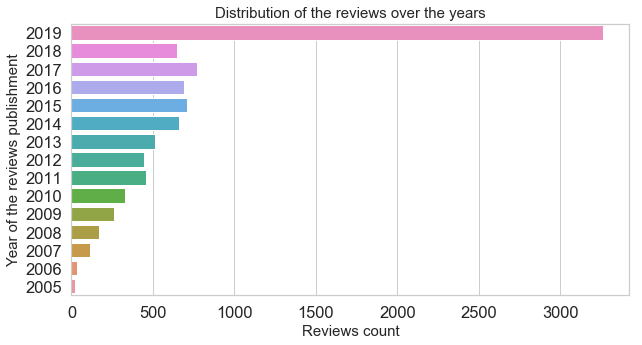

In [8]:
# Plotting the distribution of the reviews over the years
plt.figure(figsize=(10, 5))
p = sns.countplot(data = reviews, y = 'year_of_review', orient="h").invert_yaxis()
plt.title("Distribution of the reviews over the years",fontsize=15)
plt.xlabel('Reviews count',fontsize=15)
plt.ylabel('Year of the reviews publishment',fontsize=15);

### b. Business with most Five Star Reviews 

In [9]:
# We analyse ratings of reviews by getting the restaurants with most Five Star rating scores. 
ratings = reviews[reviews.rating == 5].groupby(['alias', 'rating']).agg('size').to_frame('count').reset_index().sort_values(by='count', ascending=False)
ratings[:20]

alias  rating  count
0                                 Giordano's       5   1197
10                  shaws-crab-house-chicago       5   1091
5        ginos-east-magnificent-mile-chicago       5    729
4                      ghareeb-nawaz-chicago       5    360
6                       giordanos-chicago-19       5    154
2          chipotle-mexican-grill-chicago-29       5     31
7   iyanze-restaurant-bar-and-cafe-chicago-2       5     17
3                   dominos-pizza-chicago-22       5     13
1                       chilis-too-chicago-3       5      9
8                       mcdonalds-chicago-19       5      6
9                       mcdonalds-chicago-95       5      2

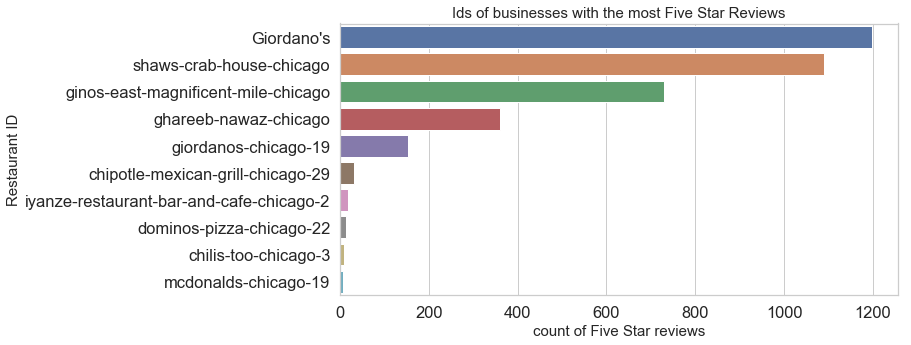

In [10]:
plt.figure(figsize=(10, 5))
#p = sns.barplot(x ='alias', y = 'count', data = ratings[:10], orient="h").invert_yaxis();
p = sns.barplot(data = ratings[:10], x='count', y = 'alias', orient="h")
plt.title("Ids of businesses with the most Five Star Reviews",fontsize=15)
plt.xlabel('count of Five Star reviews',fontsize=15)
plt.ylabel('Restaurant ID',fontsize=15);

## Shaws Crab House Chicago


In [11]:
# Get all the reviews of Shaws Crab House Chicago restaurant
shaws = reviews[reviews['alias'] == 'shaws-crab-house-chicago']

We make a word cloud of Shaws Crab House Chicago restaurant reviews to have an idea about most used words over the reviews

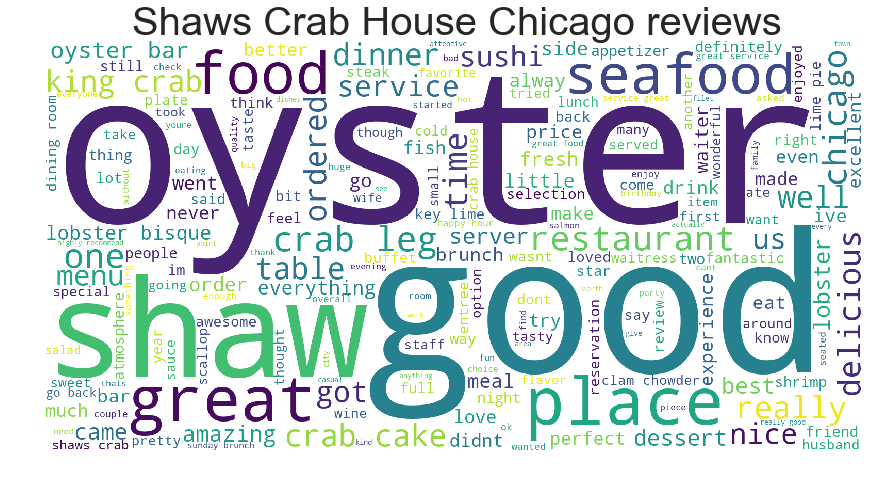

In [12]:
wc = WordCloud(background_color="white",width=1600, height=800, random_state=1, max_words=200)
# Join all strings together from the filtered description column to obtain all review text for the restaurant
wc.generate(' '.join(shaws['description_filtered']))


plt.figure(figsize=(15,10))
# Add title to figure
plt.title("Shaws Crab House Chicago reviews", fontsize=40)
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=10)

In [13]:
# We get the 10 most occuring words over the reviews. 

# Pass the split_it list to instance of Counter class. 
splitted = shaws['description_filtered'].apply(lambda x: x.split()).to_list()
flatten = [item for sublist in splitted for item in sublist]
counter = Counter(flatten) 
  
# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = counter.most_common(10) 
most_occur

[('crab', 1811),
 ('great', 1375),
 ('good', 1327),
 ('food', 1219),
 ('seafood', 1182),
 ('shaws', 1167),
 ('service', 1056),
 ('oysters', 1028),
 ('lobster', 975),
 ('place', 894)]

In [14]:
#Now we add a column which has the sentiment values of the each review posted for Shaws Crab House Chicago, to see how the 
#authors of this review feel about the restaurant.

#Create Text Blob Object and draw out the sentiment of each review by returning a value between -1.0 (extreme negative) 
#and 1.0 (extreme positive).
shaws['sentiment_analysis'] = shaws['description_filtered'].apply(lambda x: TextBlob(x).sentiment.polarity)
shaws[:10]

datePublished                                        description  \
0    2019-12-11  Not only did we have brunch on Sunday, Decembe...   
1    2019-12-07  Shaw's has been around  for quite some time in...   
2    2019-12-05  What a disappointing experience at what used t...   
3    2019-11-22  10,10,10,10,10\nthis is exactly how I feel abo...   
4    2019-10-23  Weekend brunch ... King Crab Legs ... All-You-...   
5    2019-11-15  Iesha is the best server ever!!! She checked o...   
6    2019-11-28  Last time we were here we had some hiccups. Wh...   
7    2019-12-14  I had pretty mediocre experience at Shaw's. I ...   
8    2019-10-21  There's something for everyone.... crab legs, ...   
9    2019-12-12  Classic nostalgic and fresh seafood every time...   

        author                     alias  rating  \
0  Carol A. R.  shaws-crab-house-chicago       5   
1   Richard S.  shaws-crab-house-chicago       4   
2     Emily I.  shaws-crab-house-chicago       1   
3    Ronald S.  shaws-crab-house-chicago       5   
4   Michael S.  shaws-crab-house-chicago       4   
5     Debor B.  shaws-crab-house-chicago       5   
6      John G.  shaws-crab-house-chicago       4   
7      Olga W.  shaws-crab-house-chicago       3   
8     Padma A.  shaws-crab-house-chicago       5   
9     Laura R.  shaws-crab-house-chicago       5   

                                description_filtered  year_of_review  \
0  brunch sunday december family friends marked i...            2019   
1  shaws around quite time chicagoand id consider...            2019   
2  disappointing experience used amazing seafood ...            2019   
3  exactly feel restaurant websites social inform...            2019   
4  weekend brunch king crab legs allyoucaneat per...            2019   
5  iesha best server ever checked us constant eve...            2019   
6  last time hiccups arrived packed conventioneer...            2019   
7  pretty mediocre experience shaws expect unfort...            2019   
8  theres something everyone crab legs lobster bi...            2019   
9  classic nostalgic fresh seafood every time lon...            2019   

   sentiment_analysis  
0            0.397233  
1            0.414583  
2            0.008343  
3            0.537255  
4            0.182504  
5            0.480519  
6            0.374861  
7            0.051190  
8            0.208705  
9            0.229048

In [15]:
# Now let's consider reviews of authors that gave 1 Star rating and which sentiment analysis was negative:
shaws = shaws.sort_values(by=['rating', 'sentiment_analysis'])
shaws.head()

datePublished                                        description  \
1079    2015-05-19  Worst service ever!  No lobster in lobster bis...   
1624    2011-10-16  Sat at the bar and got served a bad plate of o...   
715     2016-12-02  Ewwww. We had the crab legs with mashed potato...   
21      2019-11-01  Someone from Shaw's reached out and told me th...   
2010    2012-02-13  I ordered a cheddar burger and clam cowder fro...   

         author                     alias  rating  \
1079   Karen J.  shaws-crab-house-chicago       1   
1624   Grace E.  shaws-crab-house-chicago       1   
715     Lisa T.  shaws-crab-house-chicago       1   
21      Jori W.  shaws-crab-house-chicago       1   
2010  Daryll M.  shaws-crab-house-chicago       1   

                                   description_filtered  year_of_review  \
1079  worst service ever lobster lobster bisque butt...            2015   
1624  sat bar got served bad plate oysters oyster fe...            2011   
715   ewwww crab legs mashed potatoes mac cheese cra...            2016   
21    someone shaws reached told general manager kev...            2019   
2010  ordered cheddar burger clam cowder shaws thoug...            2012   

      sentiment_analysis  
1079           -0.916667  
1624           -0.314286  
715            -0.305000  
21             -0.266667  
2010           -0.207778

In [16]:
#shaws[:10].description.values.tolist()[8]

**Worst service ever**! No lobster in lobster bisque, butter spilled on me by waiter and **horrible waitress**.  Been going since 1980's **so disappointed**!!

Sat at the bar and got served a **bad plate** of oysters during oyster fest. The plate of oysters I was served **smelled so bad** that people at the bar several seats over **complained** about it. Told this **horror story** to a couple friends and it turns out that a girlfriend of mine dined there 2 weeks ago and ate sushi at the bar. **The entire group got horrible food poisoning**. Overrated, overpriced. Much better seafood in Chicago.

Ewwww. We had the crab legs with mashed potatoes and the mac and cheese. The crab legs were ok, but the **sides were terrible**.  We had drinks,  which were good. The pumpkin pie...ewwww, **worst pie ever**. **I hated just about everything but the drinks**. Won't waste my money there again. Was highly recommend and the let down was painful.

Someone from Shaw's reached out and told me that the General Manager, Kevin Riordan would be in touch with me to get more information regarding my review... this was nearly 2 months ago. No one ever got in touch with me. Why reach out to me if you really could care less how I feel or about my **horrible experience about this disgusting place**?! They wasted my time and theirs! I must say that all in all I'm happy, my boss said **he too was extremely disappointed and would never return**. My family won't ever give business to this place either, hey **hopefully more people will follow suit**. Try Ocean Prime instead everyone, they're not bad!

I ordered a cheddar burger and clam cowder from Shaw's as i have before. I thought the burger was unusally tough but discovered **they had melted the cheese on the burger without removing its wrapping/backing first**. I hope the 40% of this burger/wrapping i injested passing through me without **making me ill**. The delivery service informed Shaw's manager, who offered to redo the order for free and not charge me for **this crap**, but even though i asked the delivery service to have Shaw's to call me, no one has nor to my knowledge did they apologize. Check your food throughly if you order from here

**AWFUL**! I don't see how anyone can give this place even two stars. The night started out ok. The apps we got were good. Then we ordered cold crab legs for our entree and clam chowder. The clam chowder reminded me of something you'd get in a cafeteria, thick, salty and just gross. Then the crab legs at Shaws CRAB house came...they were warm...not cold enough to be cold not hot enough to be hot...we sent them back and ordered sushi. I have had better sushi at the grocery store. This was by far the **worst meal I've had in a while**. And I **didn't even mention the awful service**!

A tourist trap **to avoid**! **Extremely slow service**, you can tell kitchen is struggling with such an enormous sitting. **Everything is bad**, starting with bread, mushy and falling apart desserts and ending with **arrogant management**. Seafood and fish... you will have a better meal at Bubba Gump Shrimp or Red Lobster. **Total disappointment and waste of time and money**! Do yourself a favor go somewhere else **this place sucks**!

__________________________________________________________________________________________________________________

As observed in the above reviews, our selection got us the most negative reviews about this restaurant. We detected bad signs attesting of a bad service quality, and a bad food quality too.

We need to deepen a little more our analysis of reviews by identifying negative reviews complaining against the food quality.

In [22]:
# We get a sublist of split words for each review. These words were already filtered (lower case, stop-words removed)
words_in_reviews = [review.split() for review in shaws['description_filtered']]

In [25]:
# We count all words to see most common ones that will be used later
counts = Counter(list(flatten(words_in_reviews)))
counts.most_common(20)

[('crab', 1811),
 ('great', 1375),
 ('good', 1327),
 ('food', 1219),
 ('seafood', 1182),
 ('shaws', 1167),
 ('service', 1056),
 ('oysters', 1028),
 ('lobster', 975),
 ('place', 894),
 ('bar', 739),
 ('time', 660),
 ('chicago', 649),
 ('oyster', 580),
 ('like', 580),
 ('fresh', 578),
 ('one', 556),
 ('go', 556),
 ('restaurant', 556),
 ('really', 552)]

We create bigrams from the words of reviews

In [27]:
# Create list of lists containing bigrams in reviews
terms_bigram = [list(nltk.bigrams(word)) for word in words_in_reviews]

# View bigrams for the first review
terms_bigram[0]

[('worst', 'service'),
 ('service', 'ever'),
 ('ever', 'lobster'),
 ('lobster', 'lobster'),
 ('lobster', 'bisque'),
 ('bisque', 'butter'),
 ('butter', 'spilled'),
 ('spilled', 'waiter'),
 ('waiter', 'horrible'),
 ('horrible', 'waitress'),
 ('waitress', 'going'),
 ('going', 'since'),
 ('since', 'disappointed')]

In [28]:
# Flatten list of bigrams in clean reviews
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)

[(('crab', 'legs'), 468),
 (('king', 'crab'), 347),
 (('oyster', 'bar'), 318),
 (('lobster', 'bisque'), 281),
 (('crab', 'cakes'), 192),
 (('crab', 'cake'), 186),
 (('key', 'lime'), 166),
 (('lime', 'pie'), 152),
 (('dining', 'room'), 150),
 (('clam', 'chowder'), 140),
 (('crab', 'house'), 135),
 (('shaws', 'crab'), 118),
 (('go', 'back'), 114),
 (('great', 'service'), 112),
 (('happy', 'hour'), 108),
 (('sunday', 'brunch'), 100),
 (('service', 'great'), 100),
 (('ive', 'ever'), 96),
 (('highly', 'recommend'), 94),
 (('great', 'food'), 94)]

As we seek for analysing food-related reviews, we establish the following dictionary which will contain most occuring words of food regarding this restaurant :

In [29]:
# We picked most common words in all reviews on which will study relations with other words.
most_common_food_words = ['crab', 'food', 'seafood', 'shaws', 'oysters', 'lobster'] 

We also use a dictionary of negative words

In [30]:
negative_words = pd.read_csv('negative_words.txt', names = ['negative'])
negative_words.head()

negative
0    abnormal
1     abolish
2  abominable
3  abominably
4   abominate

Lets inspect connections between words:

In [31]:
most_common_food_words

['crab', 'food', 'seafood', 'shaws', 'oysters', 'lobster']

In [121]:
# Below is the method to analyse words and understand more the used vocabularly.
# Start by picking a word among the most occuring ones in reviews:

word = most_common_food_words[2]

In [122]:
bi = []
for i in range(len(bigrams)) :
    if(bigrams[i][0] == word and bigrams[i][1] in negative_words.negative.values.tolist()) or (((bigrams[i][0]) in negative_words.negative.values.tolist()) and bigrams[i][1] == word):
        print(bigrams[i])
        bi.append(bigrams[i])


bigram_counts = collections.Counter(bi)

bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

bigram_df

('overrated', 'seafood')
('garbage', 'seafood')
('expensive', 'seafood')
('cold', 'seafood')
('crap', 'seafood')
('cold', 'seafood')
('seafood', 'cold')
('overpriced', 'seafood')
('cold', 'seafood')
('cold', 'seafood')
('bother', 'seafood')
('seafood', 'mediocre')
('flounder', 'seafood')
('mediocre', 'seafood')
('seafood', 'fiend')
('seafood', 'hard')
('disappointment', 'seafood')
('lacking', 'seafood')
('cold', 'seafood')
('cold', 'seafood')
('worst', 'seafood')
('cold', 'seafood')
('insane', 'seafood')
('seafood', 'pricier')
('seafood', 'flair')
('seafood', 'monster')
('lacks', 'seafood')
('cold', 'seafood')
('cold', 'seafood')
('doubtful', 'seafood')
('cold', 'seafood')
('cold', 'seafood')
('seafood', 'critic')
('sucker', 'seafood')
('cold', 'seafood')
('cold', 'seafood')
('cold', 'seafood')
('seafood', 'despise')
('disappoint', 'seafood')
('nonsense', 'seafood')
('stuck', 'seafood')
('seafood', 'lacks')
('fried', 'seafood')
('cold', 'seafood')
('unhealthy', 'seafood')
('cold', 'sea

bigram  count
0             (cold, seafood)     26
1        (expensive, seafood)      2
2             (seafood, cold)      2
3            (fried, seafood)      2
4        (overrated, seafood)      1
5          (garbage, seafood)      1
6             (crap, seafood)      1
7       (overpriced, seafood)      1
8           (bother, seafood)      1
9         (seafood, mediocre)      1
10        (flounder, seafood)      1
11        (mediocre, seafood)      1
12           (seafood, fiend)      1
13            (seafood, hard)      1
14  (disappointment, seafood)      1
15         (lacking, seafood)      1
16           (worst, seafood)      1
17          (insane, seafood)      1
18         (seafood, pricier)      1
19           (seafood, flair)      1

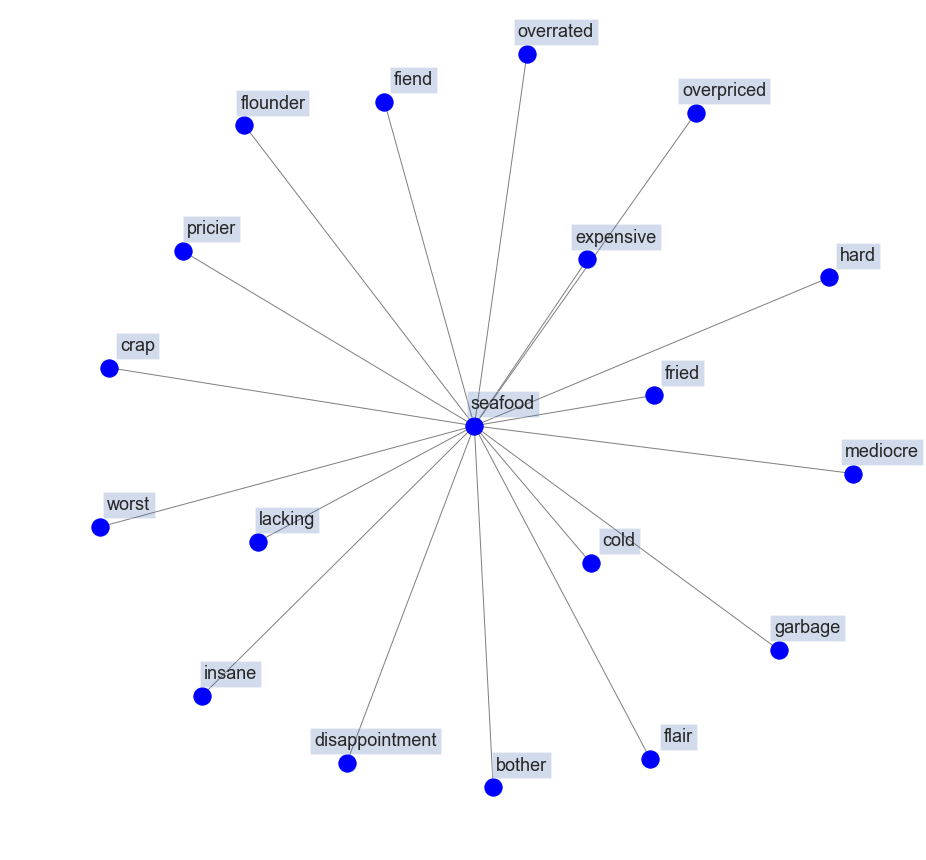

In [123]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 1))

#G.add_node("china", weight=100)
fig, ax = plt.subplots(figsize=(15, 15))

pos = nx.spring_layout(G, k=1)

# Plot networks
nx.draw(G, pos,
         font_size=20,
         width=1,
         edge_color='gray',
         node_color='blue',
         with_labels = False,
         ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.075, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict( alpha=0.25),
            horizontalalignment='center', fontsize=18)
plt.savefig('crab.png')
plt.show()
    

Our approach was first to make an overall text analysis over the reviews of this restaurant in order to have a general idea. Then, when focusing on reviews with a negative sentiment score and which had 1 Star rating, we detected a group of reviews that exhibited a critic quality food. This indeed testifies the fact that this restaurant was facing non-hygienic or maybe food poisoning city inspections. 

Then, we picked the most commun words related to the food proposed at the restaurant. We analysed their relations with differents words written in the reviews, and we have seen a large vocabulary of negative words among which there were words justifing non-higienic food service.

We can already say from this analysis that a resturant receiving such negative reviews should be targeted to take an inspection and may be prone to fail city inspections.

Now we are going to vizualise the progression of ratings over time with. We will also get back to the food inspection dataset, from which we are going to take the dates and some related informations to the city inspections happened with this restaurant. We will analyse the relation over this two subjects.

### Evolution of ratings per month

We find out the average ratings of reviews per month

In [35]:
shaws.sort_values('datePublished', ascending=True, inplace=True)
shaws['review_month_year'] = shaws.datePublished.apply(lambda x : x[:7])
shaws.head()

datePublished                                        description  \
2149    2005-08-22  Best seafood I have ever had!  A little on the...   
2057    2005-08-22  Surprisingly, a top quality seafood palace in ...   
1282    2005-08-26  This well-established restaurant is one of the...   
1800    2005-09-09  If it wasn't for the food here, I would have d...   
2065    2005-09-14  being from the east coast I am pretty fussy ab...   

          author                     alias  rating  \
2149  Valerie S.  shaws-crab-house-chicago       5   
2057  Gourmet G.  shaws-crab-house-chicago       5   
1282     Bill M.  shaws-crab-house-chicago       5   
1800      Dee W.  shaws-crab-house-chicago       4   
2065     Doug p.  shaws-crab-house-chicago       5   

                                   description_filtered  year_of_review  \
2149  best seafood ever little pricey side well wort...            2005   
2057  surprisingly top quality seafood palace shadow...            2005   
1282  wellestablished restaurant one primetime seafo...            2005   
1800  wasnt food would ditched blind date long ago c...            2005   
2065  east coast pretty fussy seafood say place top ...            2005   

      sentiment_analysis review_month_year  
2149            0.323207           2005-08  
2057            0.048864           2005-08  
1282            0.290741           2005-08  
1800            0.232143           2005-09  
2065            0.375000           2005-09

In [74]:
shaws_rating_avg = pd.DataFrame(shaws.groupby('review_month_year')['rating'].mean())
shaws_rating_avg.reset_index(inplace=True)
shaws_rating_avg.head()

review_month_year  rating
0           2005-08     5.0
1           2005-09     4.5
2           2005-10     3.0
3           2005-12     3.5
4           2006-01     3.5

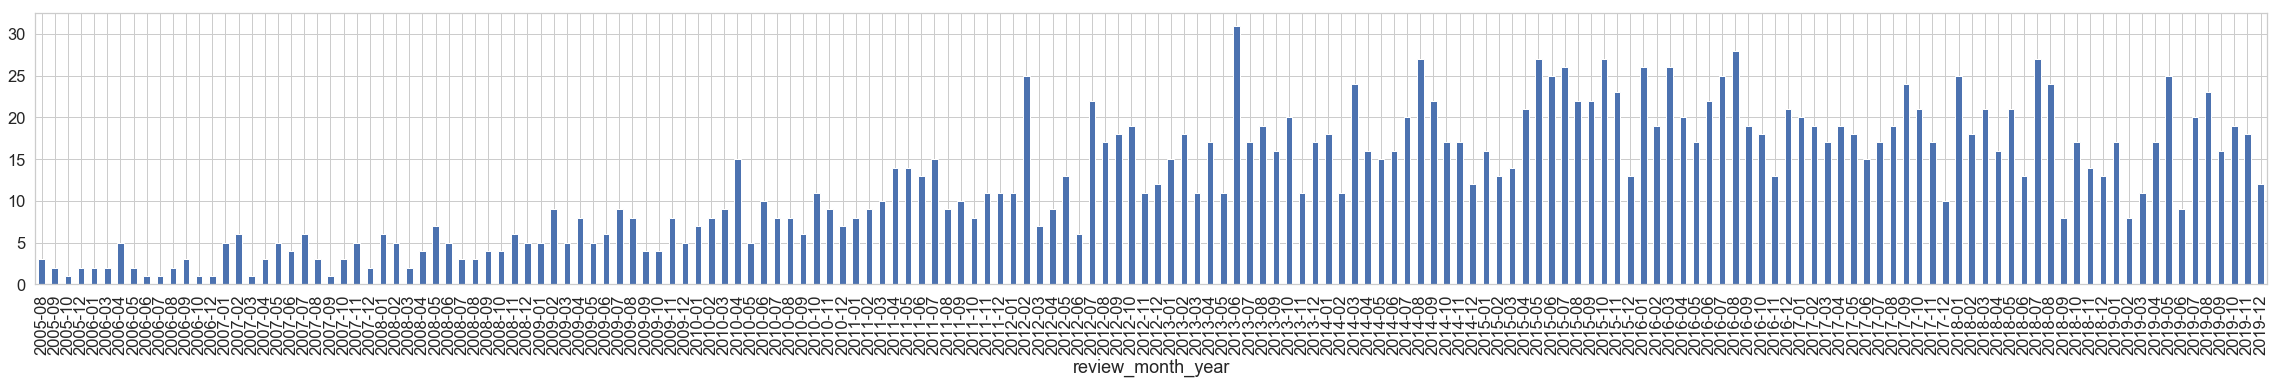

In [36]:
# We plot the number of ratings over time
plt.figure(figsize=(40,5))
shaws.groupby('review_month_year')['rating'].count().plot(kind='bar')

In [38]:
data = [go.Scatter(
          x=shaws_rating_avg.review_month_year,
          y=shaws_rating_avg['rating'])]
fig = go.Figure(data=data)
fig.update_layout(
    title="Average ratings per month",
    xaxis_title="Date of the rating",
    yaxis_title="Average rating",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    ))
fig.show()

In [71]:
data = [go.Scatter(x=insp_types['inspection_month_year'], y=insp_types['Inspection Type exact'])]
plot(data)

'temp-plot.html'

In [39]:
# load the dataset
shaws_inspections = pd.read_csv('ShawsCrabHouse_inspections.csv').drop(columns = ['Unnamed: 0'])
shaws_inspections.head()

Inspection ID          DBA Name        AKA Name  License # Facility Type  \
0         413439  shaws crab house  ShawsCrabHouse     9278.0    restaurant   
1         114568  shaws crab house  ShawsCrabHouse     9278.0    restaurant   
2         575218  shaws crab house  ShawsCrabHouse     9278.0    restaurant   
3         634460  shaws crab house  ShawsCrabHouse     9278.0    restaurant   
4        1138501  shaws crab house  ShawsCrabHouse     9278.0    restaurant   

            Risk          Address      Zip Inspection Date Inspection Type  \
0  Risk 1 (High)  21 E HUBBARD ST  60611.0      2010-09-14         canvass   
1  Risk 1 (High)  21 E HUBBARD ST  60611.0      2010-10-04       complaint   
2  Risk 1 (High)  21 E HUBBARD ST  60611.0      2011-08-30         canvass   
3  Risk 1 (High)  21 E HUBBARD ST  60611.0      2011-09-02       complaint   
4  Risk 1 (High)  21 E HUBBARD ST  60611.0      2012-09-19         canvass   

   ...                                    Violation title  \
0  ...  ['WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUC...   
1  ...                                  ['None Reported']   
2  ...  ['FOOD AND NON-FOOD CONTACT SURFACES PROPERLY ...   
3  ...                                  ['None Reported']   
4  ...  ['FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS...   

                                  Violation comments  Violation score minor  \
0  ['The walls and ceilings shall be in good repa...                      3   
1                                               ['']                      0   
2  ['ALL CUTTING BOARDS WITH DEEP/DARK GROOVES MU...                      4   
3                                               ['']                      0   
4  ['INTERIOR SURFACES OF ICE MAKER NOT CLEAN ARO...                      4   

   Violation score serious Violation score critical  Risk number  \
0                        0                        0            1   
1                        0                        0            1   
2                        0                        0            1   
3                        0                        0            1   
4                        0                        0            1   

   Inspection Type exact   Fail  Pass Pass w/ Conditions  
0                Canvass  False  True              False  
1   Short Form Complaint  False  True              False  
2                Canvass  False  True              False  
3   Short Form Complaint  False  True              False  
4                Canvass  False  True              False  

[5 rows x 29 columns]

In [66]:
shaws_inspections.sort_values('Inspection Date', ascending=True, inplace=True)
shaws_inspections['inspection_month_year'] = shaws_inspections['Inspection Date'].apply(lambda x : x[:7])
shaws_inspections.head()

Inspection ID          DBA Name        AKA Name  License # Facility Type  \
0         413439  shaws crab house  ShawsCrabHouse     9278.0    restaurant   
1         114568  shaws crab house  ShawsCrabHouse     9278.0    restaurant   
2         575218  shaws crab house  ShawsCrabHouse     9278.0    restaurant   
3         634460  shaws crab house  ShawsCrabHouse     9278.0    restaurant   
4        1138501  shaws crab house  ShawsCrabHouse     9278.0    restaurant   

            Risk          Address      Zip Inspection Date Inspection Type  \
0  Risk 1 (High)  21 E HUBBARD ST  60611.0      2010-09-14         canvass   
1  Risk 1 (High)  21 E HUBBARD ST  60611.0      2010-10-04       complaint   
2  Risk 1 (High)  21 E HUBBARD ST  60611.0      2011-08-30         canvass   
3  Risk 1 (High)  21 E HUBBARD ST  60611.0      2011-09-02       complaint   
4  Risk 1 (High)  21 E HUBBARD ST  60611.0      2012-09-19         canvass   

   ...                                 Violation comments  \
0  ...  ['The walls and ceilings shall be in good repa...   
1  ...                                               ['']   
2  ...  ['ALL CUTTING BOARDS WITH DEEP/DARK GROOVES MU...   
3  ...                                               ['']   
4  ...  ['INTERIOR SURFACES OF ICE MAKER NOT CLEAN ARO...   

  Violation score minor  Violation score serious  Violation score critical  \
0                     3                        0                         0   
1                     0                        0                         0   
2                     4                        0                         0   
3                     0                        0                         0   
4                     4                        0                         0   

  Risk number  Inspection Type exact   Fail  Pass Pass w/ Conditions  \
0           1                Canvass  False  True              False   
1           1   Short Form Complaint  False  True              False   
2           1                Canvass  False  True              False   
3           1   Short Form Complaint  False  True              False   
4           1                Canvass  False  True              False   

  inspection_month_year  
0               2010-09  
1               2010-10  
2               2011-08  
3               2011-09  
4               2012-09  

[5 rows x 30 columns]

In [67]:
shaws_inspections_redu = shaws_inspections[['Inspection ID','inspection_month_year', 'Inspection Type exact', 'Fail', 'Pass', 'Pass w/ Conditions' ]]
insp_types = shaws_inspections_redu.groupby(['inspection_month_year'])['Inspection Type exact'].apply(lambda x: ','.join(x)).reset_index()
insp_types

inspection_month_year                              Inspection Type exact
0                2010-09                                            Canvass
1                2010-10                               Short Form Complaint
2                2011-08                                            Canvass
3                2011-09                               Short Form Complaint
4                2012-09                                            Canvass
5                2013-09                                            Canvass
6                2014-09  Canvass,Suspected Food Poisoning,Suspected Foo...
7                2014-10          Short Form Complaint,Short Form Complaint
8                2014-12                               Short Form Complaint
9                2015-03                                          Complaint
10               2015-07                                          Complaint
11               2015-08                               Short Form Complaint
12               2016-06                  Complaint,Complaint Re-Inspection
13               2016-10                                          Complaint
14               2017-06                                            Canvass
15               2017-09                           Suspected Food Poisoning
16               2018-01                                          Complaint
17               2018-08                           Suspected Food Poisoning
18               2018-09                           Suspected Food Poisoning

inspection_month_year                              Inspection Type exact
0                2010-09                                            Canvass
1                2010-10                               Short Form Complaint
2                2011-08                                            Canvass
3                2011-09                               Short Form Complaint
4                2012-09                                            Canvass
5                2013-09                                            Canvass
6                2014-09  Canvass,Suspected Food Poisoning,Suspected Foo...
7                2014-10          Short Form Complaint,Short Form Complaint
8                2014-12                               Short Form Complaint
9                2015-03                                          Complaint
10               2015-07                                          Complaint
11               2015-08                               Short Form Complaint
12               2016-06                  Complaint,Complaint Re-Inspection
13               2016-10                                          Complaint
14               2017-06                                            Canvass
15               2017-09                           Suspected Food Poisoning
16               2018-01                                          Complaint
17               2018-08                           Suspected Food Poisoning
18               2018-09                           Suspected Food Poisoning

In [75]:
shaws_rating_avg= shaws_rating_avg[shaws_rating_avg.review_month_year >= '2010-05']
shaws_rating_avg

review_month_year    rating
54            2010-05  3.800000
55            2010-06  4.300000
56            2010-07  4.000000
57            2010-08  4.125000
58            2010-09  4.333333
..                ...       ...
165           2019-08  4.130435
166           2019-09  3.875000
167           2019-10  4.473684
168           2019-11  3.944444
169           2019-12  3.333333

[116 rows x 2 columns]

In [90]:
shaws_rating_avg=shaws_rating_avg[shaws_rating_avg.review_month_year >= '2014-02']

shaws_rating_avg=shaws_rating_avg[shaws_rating_avg.review_month_year <= '2018-11']

shaws_inspections_redu = shaws_inspections_redu[shaws_inspections_redu.inspection_month_year <= '2018-11']

shaws_inspections_redu=shaws_inspections_redu[shaws_inspections_redu.inspection_month_year >= '2014-02']

insp_types = insp_types[insp_types.inspection_month_year <= '2018-11']

insp_types=insp_types[insp_types.inspection_month_year >= '2014-02']

In [89]:
shaws_rating_avg.head()

inspection_month_year                              Inspection Type exact
0                2010-09                                            Canvass
1                2010-10                               Short Form Complaint
2                2011-08                                            Canvass
3                2011-09                               Short Form Complaint
4                2012-09                                            Canvass
5                2013-09                                            Canvass
6                2014-09  Canvass,Suspected Food Poisoning,Suspected Foo...
7                2014-10          Short Form Complaint,Short Form Complaint
8                2014-12                               Short Form Complaint
9                2015-03                                          Complaint
10               2015-07                                          Complaint
11               2015-08                               Short Form Complaint
12               2016-06                  Complaint,Complaint Re-Inspection
13               2016-10                                          Complaint
14               2017-06                                            Canvass
15               2017-09                           Suspected Food Poisoning
16               2018-01                                          Complaint
17               2018-08                           Suspected Food Poisoning
18               2018-09                           Suspected Food Poisoning

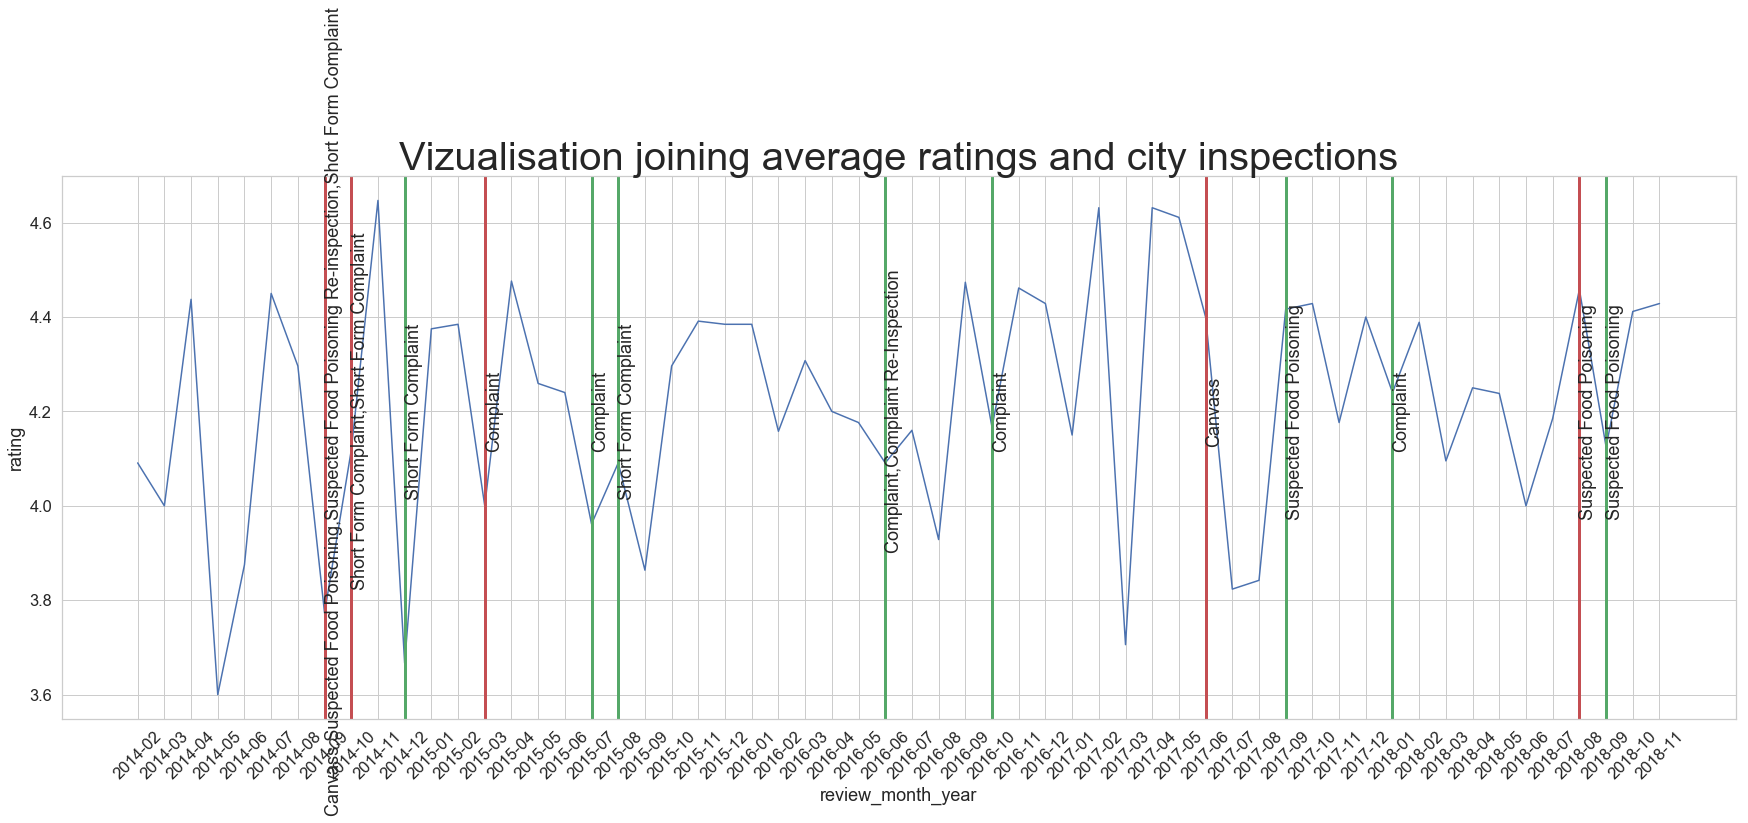

In [100]:

plt.figure(figsize=(30,10))
ax = sns.lineplot(x="review_month_year", y="rating", data=shaws_rating_avg)
ax.set_xticklabels(shaws_rating_avg.review_month_year.values.tolist(), rotation=45)
for index, row in shaws_inspections_redu.iterrows():
    
    if row.Pass == True :
        color = 'g'
    elif row.Fail == True :
        color == 'r'
    elif row['Pass w/ Conditions'] == True :
        color = 'r'
        
    plt.axvline(x=row['inspection_month_year'], color=color, linestyle='-', linewidth=3)
    
for index, row in insp_types.iterrows():
    text(row['inspection_month_year'], 4.2, row['Inspection Type exact'], rotation=90, verticalalignment='center')
plt.title('Vizualisation joining average ratings and city inspections', fontsize = 40)
plt.savefig('pp.png')